In [1]:
from captcha.image import ImageCaptcha
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

number = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
char_set = "".join(number + alphabet + ALPHABET)
char_set = "".join(number)


# 图像大小  
height = 60  
width = 160  
captcha_size = 4
n_class = len(char_set)

In [2]:
# 随机生成长度为4的字符串
def random_captcha_text(char_set = char_set, captcha_size = captcha_size):
    captcha_text = []
    for _ in range(captcha_size):
        c = random.choice(char_set)
        captcha_text.append(c)
    captcha_text = ''.join(captcha_text)
    return captcha_text

In [3]:
# 生成图片和label
def gen_captcha_text_and_image():
    image = ImageCaptcha()
    captcha_text = random_captcha_text()
    captcha = image.generate(captcha_text)
    captcha_image = Image.open(captcha)
    captcha_image = np.array(captcha_image)
    return captcha_text, captcha_image

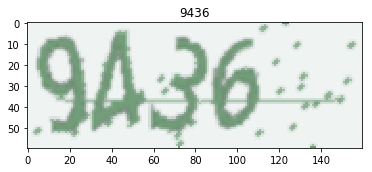

In [4]:
text, image = gen_captcha_text_and_image()
plt.title(text)
plt.imshow(image)
plt.show()

In [5]:
# 生成一个训练batch  
def get_next_batch(batch_size=32):  
    # 创建2个空数组， 用来存放一个批次的数据
    while True:
        batch_x = np.zeros((batch_size, height, width, 3))  
        batch_y = [np.zeros((batch_size, n_class)) for i in range(captcha_size)]

        # 有时生成图像大小不是(60, 160, 3)  
        def wrap_gen_captcha_text_and_image():  
            while True:  
                text, image = gen_captcha_text_and_image()  
                if image.shape == (60, 160, 3):  
                    return text, image  
    
        for i in range(batch_size):  
            text, image = gen_captcha_text_and_image()  
        
            batch_x[i,:] = image 
            # one-hot编码label
        
            for j, ch in enumerate(text):
                batch_y[j][i, :] = 0
                batch_y[j][i, char_set.find(ch)] = 1
    
        yield batch_x, batch_y 

In [6]:
from keras.models import *
from keras.layers import *
import numpy as np
import keras

def VGG16():
    input_tensor = Input((height, width, 3))
    x = input_tensor
    x = Conv2D(64, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='SAME')(x)
    x = MaxPooling2D((2, 2), padding='SAME')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='SAME')(x)
    x = MaxPooling2D((2, 2), padding='SAME')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='SAME')(x)
    x = MaxPooling2D((2, 2), padding='SAME')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='SAME')(x)
    x = MaxPooling2D((2, 2), padding='SAME')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='SAME')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='SAME')(x)
    x = MaxPooling2D((2, 2), padding='SAME')(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
    model = Model(inputs=input_tensor, outputs=x)
    return model


model = VGG16()
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

Using TensorFlow backend.


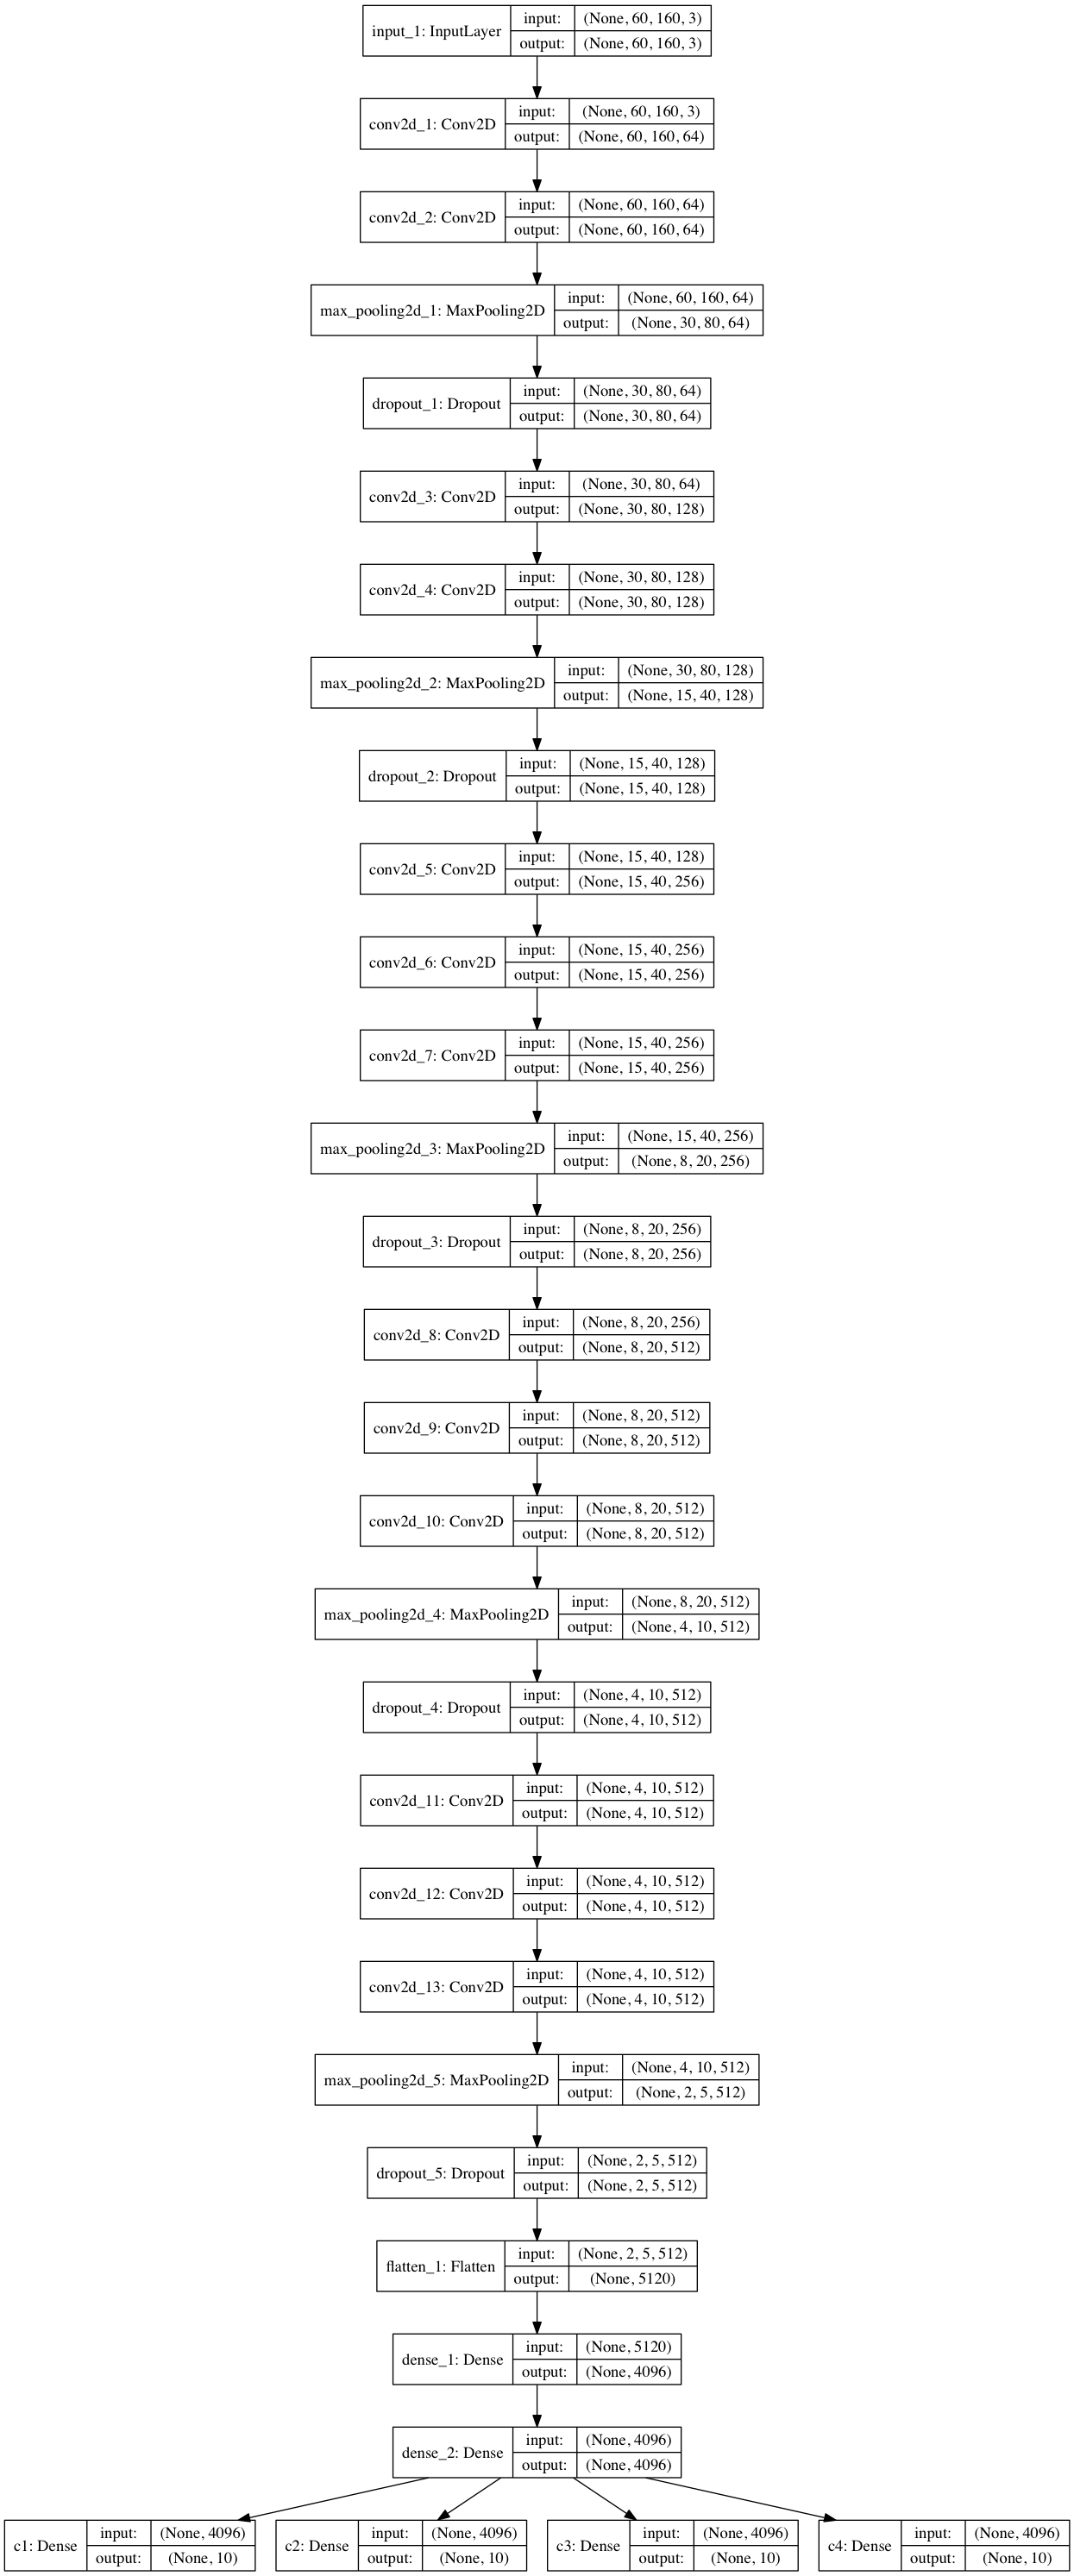

In [ ]:
import IPython.display
from keras.utils import plot_model

plot_model(model, show_shapes=True)

# 上面PIL库里面也有一个Image函数， 小心使用错误
IPython.display.Image('model.png')

In [ ]:
model.fit_generator(generator = get_next_batch(), 
                    steps_per_epoch = 100,  
                    epochs=10, 
                    verbose=2,  
                    validation_data = get_next_batch(), 
                    validation_steps = 20)

Epoch 1/10
 - 1930s - loss: 57.4758 - c1_loss: 14.4171 - c2_loss: 14.1949 - c3_loss: 14.4669 - c4_loss: 14.3969 - c1_acc: 0.1022 - c2_acc: 0.1141 - c3_acc: 0.0962 - c4_acc: 0.1028 - val_loss: 57.4963 - val_c1_loss: 14.3048 - val_c2_loss: 14.6574 - val_c3_loss: 14.4055 - val_c4_loss: 14.1285 - val_c1_acc: 0.1125 - val_c2_acc: 0.0906 - val_c3_acc: 0.1062 - val_c4_acc: 0.1234
Epoch 2/10
